
# Plant project

## Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import os
import cv2
import imghdr
import json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn import svm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras_tuner import RandomSearch

## Functions

In [2]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

In [3]:
#Multi-task model functions
# Define a simple color extraction function (based on average pixel color)
def extract_dominant_color(images):
    # Extracts the mean of RGB values as color "label"
    return np.mean(images, axis=(1, 2))

# Convert color labels to a simplified categorical (e.g., for 3 colors: red, green, blue)
def categorize_colors(colors):
    color_categories = np.zeros((colors.shape[0], 3))  # For Red, Green, Blue categories
    color_categories[np.argmax(colors, axis=1) == 0, 0] = 1  # Red
    color_categories[np.argmax(colors, axis=1) == 1, 1] = 1  # Green
    color_categories[np.argmax(colors, axis=1) == 2, 2] = 1  # Blue
    return color_categories

# Build the CNN model with two outputs
def build_multi_output_model(input_shape):
    model = Sequential()
    inputs = Input(shape=input_shape)
    
    # Add convolutional layers
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    # Flatten before feeding to dense layers
    x = Flatten()(x)

    # Shared dense layer
    x = Dense(128, activation='relu')(x)

    # Output 1: Object classification
    output_classification = Dense(10, activation='softmax', name='classification_output')(x)

    # Output 2: Color identification
    output_color = Dense(3, activation='softmax', name='color_output')(x)

    # Create a model with two outputs
    model = Model(inputs=inputs, outputs=[output_classification, output_color])
    return model

In [4]:
def VGG16(nr_of_classes, height, width,):

    model = Sequential()
    
    model.add(Input(shape=(height, width, 3)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))#32

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))#64

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),  padding='same', activation='relu'))#64

    #model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))#128

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))#256

    #model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))#256

    #model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))#256

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))#512

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))#512

    #model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))#512

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))#512

    #model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))#512

    #model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))#512

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='vgg16'))

    model.add(Flatten(name='flatten'))

    model.add(Dense(128, activation='relu', name='fc1'))#256

    model.add(Dense(64, activation='relu', name='fc2'))

    model.add(Dense(nr_of_classes, activation='softmax', name='output'))

    return model

In [5]:
def model_cnn(nr_of_classes, height, width,):
    model = Sequential()

    model.add(Input(shape=(width, height, 3)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.3))

    model.add(Dense(nr_of_classes, activation='softmax'))

    return model

In [6]:
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Input(shape=(width, height, 3)))

    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=16, max_value=64, step=8), # 32
        kernel_size=hp.Choice('conv_1_kernel_size', values=[2, 3]),
        activation='relu'
    ))
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=16), # 64
        kernel_size=hp.Choice('conv_2_kernel_size', values=[2, 3]),
        activation='relu'
    ))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=16), # 64
        kernel_size=hp.Choice('conv_3_kernel_size', values=[2, 3]),
        activation='relu'
    ))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
    
    model.add(Conv2D(
        filters=hp.Int('conv_4_filters', min_value=64, max_value=256, step=64), # 128
        kernel_size=hp.Choice('conv_4_kernel_size', values=[2, 3]),
        activation='relu'
    ))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv_5_filters', min_value=128, max_value=512, step=128), # 256
        kernel_size=hp.Choice('conv_5_kernel_size', values=[2, 3]),
        activation='relu'
    ))
    
    model.add(Conv2D(
        filters=hp.Int('conv_6_filters', min_value=256, max_value=1024, step=256), # 512
        kernel_size=hp.Choice('conv_6_kernel_size', values=[2, 3]),
        activation='relu'
    ))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
    
    # Flattening Layer
    model.add(Flatten())

    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=64, max_value=256, step=64), # 128
        activation='relu'
    ))

    model.add(Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16), # 64
        activation='relu'
    ))
    
    # Output Layer
    model.add(Dense(nr_of_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss=sparse_categorical_crossentropy,
        metrics=['accuracy']
    )

    return model

## Recurring variables

In [7]:
height = 128#256
width = 128#256
size_of_batch = 32
nr_of_classes = 30

## Load the dataset

In [8]:

# Data localy stored
data_path_train = r'data\split_ttv_dataset_type_of_plants\Train_Set_Folder'
data_path_val = r'data\split_ttv_dataset_type_of_plants\Validation_Set_Folder'
data_path_test = r'data\split_ttv_dataset_type_of_plants\Test_Set_Folder'


data_train = tf.keras.utils.image_dataset_from_directory(data_path_train, image_size=(width, height)) 
data_val = tf.keras.utils.image_dataset_from_directory(data_path_val, image_size=(width, height))
data_test = tf.keras.utils.image_dataset_from_directory(data_path_test, image_size=(width, height))

train_labels = np.concatenate([y for x, y in data_train], axis=0)
val_labels = np.concatenate([y for x, y in data_val], axis=0)
test_labels = np.concatenate([y for x, y in data_test], axis=0)

data_train_iterator = data_train.as_numpy_iterator()
data_val_iterator = data_val.as_numpy_iterator()
data_test_iterator = data_test.as_numpy_iterator()

Found 23972 files belonging to 30 classes.
Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.


In [9]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
# Lables from json file
path_to_json = r'data\plantnet_300K\plantnet300K_species_id_2_name.json'

plantnet300K_names = json.load(open(path_to_json, encoding='utf-8'))

print(plantnet300K_names)
print(plantnet300K_names['1355920'])

{'1355868': 'Lactuca virosa L.', '1355920': "Pelargonium capitatum (L.) L'Hér.", '1355932': "Pelargonium graveolens L'Hér.", '1355936': 'Cirsium arvense (L.) Scop.', '1355937': 'Cirsium vulgare (Savi) Ten.', '1355955': "Pelargonium odoratissimum (L.) L'Hér.", '1355959': "Pelargonium peltatum (L.) L'Hér.", '1355961': "Pelargonium quercifolium (L. f.) L'Hér.", '1355978': "Pelargonium zonale (L.) L'Hér.", '1355990': 'Mercurialis annua L.', '1356003': 'Phyllanthus tenellus Roxb.', '1356022': 'Hypericum perforatum L.', '1356037': 'Egeria densa Planch.', '1356055': 'Ibicella lutea (Lindl.) Van Eselt.', '1356075': 'Tradescantia fluminensis Vell.', '1356076': 'Tradescantia zebrina Heynh. ex Bosse', '1356111': 'Lamium amplexicaule L.', '1356126': 'Lavandula dentata L.', '1356138': 'Striga asiatica (L.) Kuntze', '1356257': 'Melilotus albus Medik.', '1356278': 'Trifolium fragiferum L.', '1356279': 'Asystasia gangetica (L.) T. Anderson', '1356309': 'Nymphaea nouchali Burm. f.', '1356379': 'Dryopte

In [11]:
# Load CIFAR-10 dataset 
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to categorical (for classification task)
train_labels_class = to_categorical(train_labels, 10)
test_labels_class = to_categorical(test_labels, 10)

# Get color labels (as a separate task for color classification)
train_colors = extract_dominant_color(train_images)
test_colors = extract_dominant_color(test_images)

train_colors_cat = categorize_colors(train_colors)
test_colors_cat = categorize_colors(test_colors)

In [12]:
batch_train = data_train_iterator.next()
batch_val = data_val_iterator.next()
batch_test = data_test_iterator.next()

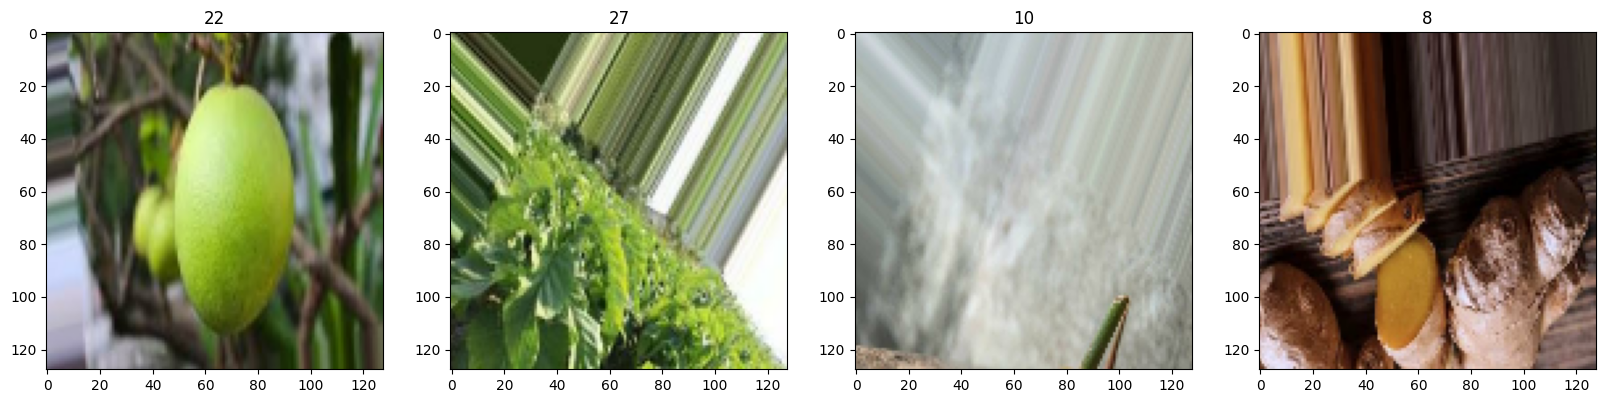

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_train[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch_train[1][idx])

## Scale the data

In [14]:
train = data_train.map(lambda x,y: (x/255, y))
val = data_val.map(lambda x,y: (x/255, y))
test = data_test.map(lambda x,y: (x/255, y))

In [15]:
train.as_numpy_iterator().next()
val.as_numpy_iterator().next()
test.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.8363195 , 0.8038481 , 0.36176577],
          [0.9384712 , 0.8922861 , 0.58574444],
          [0.9736797 , 0.9207761 , 0.7307535 ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.7863512 , 0.7681036 , 0.28686297],
          [0.8268169 , 0.7952906 , 0.43536353],
          [0.9420367 , 0.9040563 , 0.6571458 ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.7176572 , 0.72913074, 0.17871729],
          [0.7439829 , 0.7369455 , 0.296054  ],
          [0.8636959 , 0.84191287, 0.5040891 ]],
 
         ...,
 
         [[0.99407166, 0.99407166, 0.99407166],
          [0.99215

## Build the model

In [14]:
model = Sequential()

model.add(Input(shape=(height, width, 3)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(nr_of_classes, activation='softmax'))

model.compile(optimizer=Adam(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
# Define multi model
input_shape = train_images.shape[1:]
multi_model = build_multi_output_model(input_shape)

# Compile the model
multi_model.compile(optimizer='adam',
              loss={'classification_output': 'categorical_crossentropy', 'color_output': 'categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'color_output': 'accuracy'})

multi_model.summary()

In [ ]:
# Train the multi model
history = multi_model.fit(train_images, 
                    {'classification_output': train_labels_class, 'color_output': train_colors_cat},
                    epochs=10, 
                    batch_size=64, 
                    validation_data=(test_images, 
                                     {'classification_output': test_labels_class, 'color_output': test_colors_cat}))

In [ ]:
# VGG16
model_vgg16 = VGG16(nr_of_classes, height, width)

#opt = SGD(learning_rate=0.001, momentum=0.9)

model_vgg16.compile(loss=sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model_vgg16.summary()

In [ ]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)

h = model_vgg16.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[es])

In [ ]:
model_name = "model-vgg16_modifyed_v2.h5"
model_vgg16.save(model_name)

score = model_vgg16.evaluate(test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# CNN
model_cnn = model_cnn(nr_of_classes, height, width)
model_cnn.compile(loss=sparse_categorical_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

model_cnn.summary()

In [ ]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)

his = model_cnn.fit(train, validation_data=val, epochs=15, verbose=1, callbacks=[es])

In [ ]:
model_name = "model-cnn-v2.h5"
model_cnn.save(model_name)

score = model_cnn.evaluate(test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
multi_model_name = "multi_model-v1.h5"
multi_model.save(multi_model_name)
# Evaluate the model
loss, class_loss, color_loss, class_acc, color_acc = multi_model.evaluate(test_images, 
                                                                    {'classification_output': test_labels_class, 
                                                                     'color_output': test_colors_cat})

print(f"Classification Accuracy: {class_acc}")
print(f"Color Identification Accuracy: {color_acc}")

In [ ]:
# Visualize training history
plt.plot(history.history['classification_output_accuracy'], label='Classification Accuracy')
plt.plot(history.history['color_output_accuracy'], label='Color Identification Accuracy')
plt.legend()
plt.show()

# Predict on a sample image
sample_image = test_images[0:1]  # Choose a sample image
predictions = multi_model.predict(sample_image)

print("Predicted Class:", np.argmax(predictions[0]))
print("Predicted Color:", np.argmax(predictions[1]))

## Tune model

In [24]:
tuner = RandomSearch(build_model,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1, 
    project_name='cnn_tuning_v2')

Reloading Tuner from .\cnn_tuning_v2\tuner0.json


In [25]:
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    patience=3, 
    restore_best_weights=True
)

In [26]:
tuner.search(
    train,
    validation_data=(val),
    epochs=12,
    callbacks=[early_stopping_monitor],
    verbose=2
)

Trial 12 Complete [01h 57m 43s]
val_accuracy: 0.656105637550354

Best val_accuracy So Far: 0.7052805423736572
Total elapsed time: 17h 56m 41s


In [27]:
tuner.results_summary()

Results summary
Results in .\cnn_tuning_v2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 5 summary
Hyperparameters:
conv_1_filters: 56
conv_1_kernel_size: 3
conv_2_filters: 64
conv_2_kernel_size: 3
conv_3_filters: 96
conv_3_kernel_size: 3
conv_4_filters: 256
conv_4_kernel_size: 2
conv_5_filters: 256
conv_5_kernel_size: 2
conv_6_filters: 512
conv_6_kernel_size: 3
dense_1_units: 256
dense_2_units: 64
optimizer: rmsprop
Score: 0.7052805423736572

Trial 10 summary
Hyperparameters:
conv_1_filters: 24
conv_1_kernel_size: 2
conv_2_filters: 32
conv_2_kernel_size: 2
conv_3_filters: 128
conv_3_kernel_size: 2
conv_4_filters: 256
conv_4_kernel_size: 3
conv_5_filters: 384
conv_5_kernel_size: 3
conv_6_filters: 256
conv_6_kernel_size: 2
dense_1_units: 64
dense_2_units: 80
optimizer: adam
Score: 0.698019802570343

Trial 08 summary
Hyperparameters:
conv_1_filters: 64
conv_1_kernel_size: 2
conv_2_filters: 128
conv_2_kernel_size: 2
conv_3_filters: 112
conv_3_kernel_size: 2